## Sentiment to Strategy: Leveraging Forums Discussions to Guide Automated Trading Decisions 

---

### 0. Importing libraries

In [50]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import praw
import csv
import time
from datetime import datetime, timedelta
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
import string
import yfinance as yf   
from pathlib import Path

---

### 1. Reddit API Data Extraction and Manipulation

In [51]:
# Initialize PRAW (Python Reddit API Wrapper)
user_agent = "StockMarket Sentiment Analysis"
reddit = praw.Reddit(
    client_id="SDD6BO5WvswKQ2DOZrioiQ",
    client_secret="BoGTdq9xg1Wu4kjy3zj_WBLbTInQvQ",
    user_agent=user_agent
)

# Initialize the subreddit
subreddit = reddit.subreddit("wallstreetbets")

In [52]:
# List to hold data for each post
posts = []

# Fetch posts from the subreddit
for submission in subreddit.new(limit=None):
    post_date = datetime.fromtimestamp(submission.created_utc)
    posts.append({
        'id': submission.id,
        'title': submission.title,
        'selftext': submission.selftext,
        'score': submission.score,
        'upvote_ratio': submission.upvote_ratio,       
        'created_date': post_date,
        'permalink': f"https://redd.it/{submission.id}"
    })

# Convert the list to a DataFrame
raw_df = pd.DataFrame(posts)
raw_df

,id,title,selftext,score,upvote_ratio,created_date,permalink
0,1kv5z3j,Need suggestions thank you,I personally do own Google and it's my 2nd bi...,1,1.00,2025-05-25 18:00:16,https://redd.it/1kv5z3j
1,1kv5whz,"US EV market is cooked, $250 annual fee on ev,...",EV Credits\n\nThe bill would eliminate or subs...,2,0.60,2025-05-25 17:57:07,https://redd.it/1kv5whz
2,1kv58dx,"Repost of my DD for VVX, $1.5B company with ov...",I'm dumb and I didn't know I had to post scree...,15,0.74,2025-05-25 17:28:04,https://redd.it/1kv58dx
3,1kv56be,First post ROST put,Overnight ROST 135 aug 15 put \n\nBought befor...,5,0.78,2025-05-25 17:25:37,https://redd.it/1kv56be
4,1kutran,Am I cooked chat?,Calls calls calls,0,0.45,2025-05-25 06:08:13,https://redd.it/1kutran
...,...,...,...,...,...,...,...
851,1kd9rwt,call me bill ackman. $329K > $66K > $349K,live to die another day,2160,0.97,2025-05-02 21:37:17,https://redd.it/1kd9rwt
852,1kd973i,"Before I get banned for the week, Meta. Gl",,10,0.86,2025-05-02 21:12:39,https://redd.it/1kd973i
853,1kd8nus,"Tariff this, tariff that, America wins",,373,0.68,2025-05-02 20:50:15,https://redd.it/1kd8nus
854,1kd8adg,$NKE,Keep trolling.,26,0.85,2025-05-02 20:33:58,https://redd.it/1kd8adg


In [53]:
# Create a csv file with the data
if os.path.exists('wsb_posts.csv'):
    existing_df = pd.read_csv('wsb_posts.csv')
    combined_df = pd.concat([existing_df, raw_df]).drop_duplicates(subset=['id'])
    combined_df.to_csv('wsb_posts.csv', index=False)
else:
    raw_df.to_csv('wsb_posts.csv', index=False)

In [54]:
# Load the data from the csv file
df = pd.read_csv('wsb_posts.csv')
df

,id,title,selftext,score,upvote_ratio,created_date,permalink,text
0,1kqotlw,Whats your opinion about Rocket Lab?,I see many ppl hyping rocket lab and also boug...,1,1.00,2025-05-20 00:12:16,https://redd.it/1kqotlw,Whats your opinion about Rocket Lab? I see man...
1,1kqoadm,Fed's Powell has sounded the alarm for years a...,NaN,125,0.94,2025-05-19 23:49:38,https://redd.it/1kqoadm,Fed's Powell has sounded the alarm for years a...
2,1kqo5u3,Big beautiful bill,Am I screwed with my sp500 ETFs as a French in...,0,0.25,2025-05-19 23:44:20,https://redd.it/1kqo5u3,Big beautiful bill Am I screwed with my sp500 ...
3,1kqo1xz,Question on UNH Stock,"Should I sell UNH calls, covered calls or hold...",11,0.87,2025-05-19 23:39:50,https://redd.it/1kqo1xz,"Question on UNH Stock Should I sell UNH calls,..."
4,1kqmxov,Is this gonna print tomorrow,"Held these over the weekend, at its peak today...",0,0.44,2025-05-19 22:54:47,https://redd.it/1kqmxov,Is this gonna print tomorrow Held these over t...
...,...,...,...,...,...,...,...,...
1148,1kv58dx,"Repost of my DD for VVX, $1.5B company with ov...",I'm dumb and I didn't know I had to post scree...,3,0.71,2025-05-25 17:28:04,https://redd.it/1kv58dx,NaN
1149,1kv56be,First post ROST put,Overnight ROST 135 aug 15 put \n\nBought befor...,2,0.75,2025-05-25 17:25:37,https://redd.it/1kv56be,NaN
1150,1kv54gp,4th of July bet,Am I the only person Trump will announce somet...,6,0.67,2025-05-25 17:23:23,https://redd.it/1kv54gp,NaN
1151,1kv5z3j,Need suggestions thank you,I personally do own Google and it's my 2nd bi...,1,1.00,2025-05-25 18:00:16,https://redd.it/1kv5z3j,NaN


In [55]:
# Read the S&P 500 companies list from the CSV file
csv_file = 'stocks.csv'
stocks_df = pd.read_csv(csv_file)

# Extract the ticker symbols (the column is usually named "Symbol")
tickers = stocks_df['Symbol'].tolist()

# Extract the names of the companies
companies = stocks_df['Name'].tolist()

In [56]:
# Combine title and selftext into one column to search both
raw_df['text'] = raw_df['title'].fillna('') + " " + raw_df['selftext'].fillna('')

# Filter only the needed columns
filtered_reddit = raw_df.copy()
filtered_reddit.drop(columns=['title', 'selftext', 'score', 'upvote_ratio'], axis=1, inplace=True)
filtered_reddit

,id,created_date,permalink,text
0,1kv5z3j,2025-05-25 18:00:16,https://redd.it/1kv5z3j,Need suggestions thank you I personally do ow...
1,1kv5whz,2025-05-25 17:57:07,https://redd.it/1kv5whz,"US EV market is cooked, $250 annual fee on ev,..."
2,1kv58dx,2025-05-25 17:28:04,https://redd.it/1kv58dx,"Repost of my DD for VVX, $1.5B company with ov..."
3,1kv56be,2025-05-25 17:25:37,https://redd.it/1kv56be,First post ROST put Overnight ROST 135 aug 15 ...
4,1kutran,2025-05-25 06:08:13,https://redd.it/1kutran,Am I cooked chat? Calls calls calls
...,...,...,...,...
851,1kd9rwt,2025-05-02 21:37:17,https://redd.it/1kd9rwt,call me bill ackman. $329K > $66K > $349K live...
852,1kd973i,2025-05-02 21:12:39,https://redd.it/1kd973i,"Before I get banned for the week, Meta. Gl"
853,1kd8nus,2025-05-02 20:50:15,https://redd.it/1kd8nus,"Tariff this, tariff that, America wins"
854,1kd8adg,2025-05-02 20:33:58,https://redd.it/1kd8adg,$NKE Keep trolling.


In [57]:
# Create a mapping from cleaned company names (lowercase) to their corresponding ticker
company_mapping = {company.lower(): ticker for company, ticker in zip(companies, tickers)}

# Find matching tickers in the text, replacing company name matches with their stock codes
def matching_tickers(text):
    matched = [str(ticker) for ticker in tickers if str(ticker) in text]
    for company in companies:
        if company.lower() in text.lower():
            ticker_code = company_mapping.get(company.lower())
            if ticker_code:
                matched.append(ticker_code)
    return matched

# Apply the matching function to the 'text' column and remove duplicates
filtered_reddit['tickers'] = filtered_reddit['text'].apply(matching_tickers)
filtered_reddit['tickers'] = filtered_reddit['tickers'].apply(lambda x: list(set(x)))
filtered_reddit

,id,created_date,permalink,text,tickers
0,1kv5z3j,2025-05-25 18:00:16,https://redd.it/1kv5z3j,Need suggestions thank you I personally do ow...,"[B, G, H, T, A, W, C]"
1,1kv5whz,2025-05-25 17:57:07,https://redd.it/1kv5whz,"US EV market is cooked, $250 annual fee on ev,...","[E, U, T, S, V, A, C]"
2,1kv58dx,2025-05-25 17:28:04,https://redd.it/1kv58dx,"Repost of my DD for VVX, $1.5B company with ov...","[B, X, DD, L, AM, W, U, J, E, ET, H, M, FI, LC..."
3,1kv56be,2025-05-25 17:25:37,https://redd.it/1kv56be,First post ROST put Overnight ROST 135 aug 15 ...,"[ST, O, B, T, S, OST, ROST, OS, R, F]"
4,1kutran,2025-05-25 06:08:13,https://redd.it/1kutran,Am I cooked chat? Calls calls calls,"[C, A]"
...,...,...,...,...,...
851,1kd9rwt,2025-05-02 21:37:17,https://redd.it/1kd9rwt,call me bill ackman. $329K > $66K > $349K live...,[K]
852,1kd973i,2025-05-02 21:12:39,https://redd.it/1kd973i,"Before I get banned for the week, Meta. Gl","[G, M, B]"
853,1kd8nus,2025-05-02 20:50:15,https://redd.it/1kd8nus,"Tariff this, tariff that, America wins","[A, T]"
854,1kd8adg,2025-05-02 20:33:58,https://redd.it/1kd8adg,$NKE Keep trolling.,"[NKE, E, KE, K]"


In [58]:
# Remove substring tickers
def remove_substring_tickers(tickers):
    # Remove duplicates
    tickers = list(set(tickers))
    # Sort tickers by length in descending order
    tickers.sort(key=len, reverse=True)
    # Create a new list to store the filtered tickers
    filtered_tickers = []
    for ticker in tickers:
        # Check if the ticker is a substring of any other ticker in the list
        if not any(ticker in other_ticker for other_ticker in tickers if ticker != other_ticker):
            filtered_tickers.append(ticker)
    return filtered_tickers

# Apply the function to the filtered_reddit['tickers'] column
filtered_reddit['tickers'] = filtered_reddit['tickers'].apply(remove_substring_tickers)
filtered_reddit

,id,created_date,permalink,text,tickers
0,1kv5z3j,2025-05-25 18:00:16,https://redd.it/1kv5z3j,Need suggestions thank you I personally do ow...,"[B, G, H, T, A, W, C]"
1,1kv5whz,2025-05-25 17:57:07,https://redd.it/1kv5whz,"US EV market is cooked, $250 annual fee on ev,...","[E, T, S, V, A, C, U]"
2,1kv58dx,2025-05-25 17:28:04,https://redd.it/1kv58dx,"Repost of my DD for VVX, $1.5B company with ov...","[VVX, DD, AM, ET, FI, LC, TS, B, W, U, J, H, O..."
3,1kv56be,2025-05-25 17:25:37,https://redd.it/1kv56be,First post ROST put Overnight ROST 135 aug 15 ...,"[ROST, B, F]"
4,1kutran,2025-05-25 06:08:13,https://redd.it/1kutran,Am I cooked chat? Calls calls calls,"[C, A]"
...,...,...,...,...,...
851,1kd9rwt,2025-05-02 21:37:17,https://redd.it/1kd9rwt,call me bill ackman. $329K > $66K > $349K live...,[K]
852,1kd973i,2025-05-02 21:12:39,https://redd.it/1kd973i,"Before I get banned for the week, Meta. Gl","[G, M, B]"
853,1kd8nus,2025-05-02 20:50:15,https://redd.it/1kd8nus,"Tariff this, tariff that, America wins","[A, T]"
854,1kd8adg,2025-05-02 20:33:58,https://redd.it/1kd8adg,$NKE Keep trolling.,[NKE]


In [59]:
# Remove ambiguous tickers
ambiguous_tickers = (
    list(string.ascii_uppercase)  # single-letter symbols
    + [
        # two-letter everyday words / abbreviations
        "AI", "EV", "IT", "ON", "OR", "NO", "OK", "GO", "SO", "DO", "UP", "EU", "US", "IP", "KO",
        "AM", "PM", "HI", "IN", "AT", "TO", "BY", "MY", "WE", "ME", "HE", "IT", "IS", "AS", "AN",
        # three- to four-letter common words
        "ALL", "FUN", "BIG", "RUN", "NEW", "TOP", "YOU", "CAT", "DOG", "CAR", "SUN", "USA", 
        "IPO", "CAN", "NOW", "AND", "FOR", "OUT", "BUY", "WIN", "LOW", "HIGH", "LOVE", "HATE",
        "EDIT", "TEST", "DATA", "CODE", "TEAM", "WORK", "PLAY", "TIME", "GAME", "NEXT", "BEST",
        "ONE", "TWO", "THREE", "FOUR", "FIVE", "SIX", "SEVEN", "EIGHT", "NINE", "TEN",
        # tech buzz-terms
        "CPU", "GPU", "VR", "AR", "NFT", "ML",
        # meme & slang tickers
        "YOLO", "HODL", "MOON", "LMAO", "LOL", "FOMO", "FUD", "WTF", "BULL", "BEAR",
        # other 
        "Reddit", "WSB", "nan", "NAN"
    ])

# Remove ambiguous tickers from the filtered_reddit['tickers'] column
def remove_ambiguous_tickers(tickers):
    # Remove duplicates
    tickers = list(set(tickers))
    # Filter out ambiguous tickers
    tickers = [ticker for ticker in tickers if ticker not in ambiguous_tickers]
    return tickers

# Apply the function to the filtered_reddit['tickers'] column
filtered_reddit['tickers'] = filtered_reddit['tickers'].apply(remove_ambiguous_tickers)
filtered_reddit

,id,created_date,permalink,text,tickers
0,1kv5z3j,2025-05-25 18:00:16,https://redd.it/1kv5z3j,Need suggestions thank you I personally do ow...,[]
1,1kv5whz,2025-05-25 17:57:07,https://redd.it/1kv5whz,"US EV market is cooked, $250 annual fee on ev,...",[]
2,1kv58dx,2025-05-25 17:28:04,https://redd.it/1kv58dx,"Repost of my DD for VVX, $1.5B company with ov...","[ET, DD, TS, FI, LC, VVX]"
3,1kv56be,2025-05-25 17:25:37,https://redd.it/1kv56be,First post ROST put Overnight ROST 135 aug 15 ...,[ROST]
4,1kutran,2025-05-25 06:08:13,https://redd.it/1kutran,Am I cooked chat? Calls calls calls,[]
...,...,...,...,...,...
851,1kd9rwt,2025-05-02 21:37:17,https://redd.it/1kd9rwt,call me bill ackman. $329K > $66K > $349K live...,[]
852,1kd973i,2025-05-02 21:12:39,https://redd.it/1kd973i,"Before I get banned for the week, Meta. Gl",[]
853,1kd8nus,2025-05-02 20:50:15,https://redd.it/1kd8nus,"Tariff this, tariff that, America wins",[]
854,1kd8adg,2025-05-02 20:33:58,https://redd.it/1kd8adg,$NKE Keep trolling.,[NKE]


In [60]:
def keep_standalone_tickers(row):
    sentence = row["text"]
    cleaned = []
    for tkr in row["tickers"]:
        # look for the ticker as an independent token, optionally prefixed with $
        # (?<![A-Za-z0-9])  → left boundary is NOT a letter/number
        # (?![A-Za-z0-9])   → right boundary is NOT a letter/number
        pattern = rf'(?<![A-Za-z0-9])\$?{re.escape(tkr)}(?![A-Za-z0-9])'
        if re.search(pattern, sentence):
            cleaned.append(tkr)
    return cleaned

filtered_reddit["tickers"] = filtered_reddit.apply(keep_standalone_tickers, axis=1)
filtered_reddit

,id,created_date,permalink,text,tickers
0,1kv5z3j,2025-05-25 18:00:16,https://redd.it/1kv5z3j,Need suggestions thank you I personally do ow...,[]
1,1kv5whz,2025-05-25 17:57:07,https://redd.it/1kv5whz,"US EV market is cooked, $250 annual fee on ev,...",[]
2,1kv58dx,2025-05-25 17:28:04,https://redd.it/1kv58dx,"Repost of my DD for VVX, $1.5B company with ov...","[DD, VVX]"
3,1kv56be,2025-05-25 17:25:37,https://redd.it/1kv56be,First post ROST put Overnight ROST 135 aug 15 ...,[ROST]
4,1kutran,2025-05-25 06:08:13,https://redd.it/1kutran,Am I cooked chat? Calls calls calls,[]
...,...,...,...,...,...
851,1kd9rwt,2025-05-02 21:37:17,https://redd.it/1kd9rwt,call me bill ackman. $329K > $66K > $349K live...,[]
852,1kd973i,2025-05-02 21:12:39,https://redd.it/1kd973i,"Before I get banned for the week, Meta. Gl",[]
853,1kd8nus,2025-05-02 20:50:15,https://redd.it/1kd8nus,"Tariff this, tariff that, America wins",[]
854,1kd8adg,2025-05-02 20:33:58,https://redd.it/1kd8adg,$NKE Keep trolling.,[NKE]


In [61]:
# Remove rows with empty 'tickers' list
filtered_reddit = filtered_reddit[filtered_reddit['tickers'].str.len() > 0]
filtered_reddit

,id,created_date,permalink,text,tickers
2,1kv58dx,2025-05-25 17:28:04,https://redd.it/1kv58dx,"Repost of my DD for VVX, $1.5B company with ov...","[DD, VVX]"
3,1kv56be,2025-05-25 17:25:37,https://redd.it/1kv56be,First post ROST put Overnight ROST 135 aug 15 ...,[ROST]
5,1kupmur,2025-05-25 02:12:37,https://redd.it/1kupmur,Who riding the $UNH train with me 🚂🚂🚂 Lets ride,[UNH]
6,1kuoxss,2025-05-25 01:36:03,https://redd.it/1kuoxss,[With Clear Positions] Analysts Expect First E...,"[NVDA, CMC]"
8,1kuo4zl,2025-05-25 00:56:01,https://redd.it/1kuo4zl,"Sold puts on NVDA, got assigned, now have $250...",[NVDA]
...,...,...,...,...,...
842,1kdcv86,2025-05-02 23:50:26,https://redd.it/1kdcv86,The war is over Thanks to TSM and NFLX big pul...,"[TSM, NFLX]"
846,1kdbcow,2025-05-02 22:44:25,https://redd.it/1kdbcow,I don’t even know wtf I’m doing at this point....,[AAPL]
847,1kdbcbf,2025-05-02 22:43:57,https://redd.it/1kdbcbf,"Nearly 800% gain, thanks PLTR! Couldn't take t...",[PLTR]
848,1kdaghu,2025-05-02 22:06:19,https://redd.it/1kdaghu,Still not tired of winning Withdrew a bit and ...,[JD]


---

### 2. Sentiment Analysis

In [62]:
device = 0 if torch.cuda.is_available() else -1      # -1 ⇒ CPU
model_id = "ProsusAI/finBERT"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device==0 else torch.float32
)

sent_pipe1 = pipeline(
    task="sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=device,
    return_all_scores=True,    # **preferred** to top_k=None
    truncation=True
)

Device set to use cuda:0
C:\Users\andry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [63]:
LABEL_TO_POLARITY = {"positive": +1, "neutral": 0, "negative": -1}

def finbert_score(text: str) -> float:
    scores = sent_pipe1(text, batch_size=1)[0]           # list[dict]
    # Convert to dict {label: prob}
    scores = {d["label"].lower(): d["score"] for d in scores}

    # Simple +/− difference (prob_pos − prob_neg)
    return scores["positive"] - scores["negative"]

filtered_reddit["sentiment"] = filtered_reddit["text"].apply(finbert_score)
filtered_reddit

C:\Users\andry\AppData\Local\Temp\ipykernel_12436\614457924.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_reddit["sentiment"] = filtered_reddit["text"].apply(finbert_score)


,id,created_date,permalink,text,tickers,sentiment
2,1kv58dx,2025-05-25 17:28:04,https://redd.it/1kv58dx,"Repost of my DD for VVX, $1.5B company with ov...","[DD, VVX]",0.015748
3,1kv56be,2025-05-25 17:25:37,https://redd.it/1kv56be,First post ROST put Overnight ROST 135 aug 15 ...,[ROST],0.007510
5,1kupmur,2025-05-25 02:12:37,https://redd.it/1kupmur,Who riding the $UNH train with me 🚂🚂🚂 Lets ride,[UNH],0.037919
6,1kuoxss,2025-05-25 01:36:03,https://redd.it/1kuoxss,[With Clear Positions] Analysts Expect First E...,"[NVDA, CMC]",-0.948139
8,1kuo4zl,2025-05-25 00:56:01,https://redd.it/1kuo4zl,"Sold puts on NVDA, got assigned, now have $250...",[NVDA],0.336148
...,...,...,...,...,...,...
842,1kdcv86,2025-05-02 23:50:26,https://redd.it/1kdcv86,The war is over Thanks to TSM and NFLX big pul...,"[TSM, NFLX]",0.880135
846,1kdbcow,2025-05-02 22:44:25,https://redd.it/1kdbcow,I don’t even know wtf I’m doing at this point....,[AAPL],0.088753
847,1kdbcbf,2025-05-02 22:43:57,https://redd.it/1kdbcbf,"Nearly 800% gain, thanks PLTR! Couldn't take t...",[PLTR],0.035552
848,1kdaghu,2025-05-02 22:06:19,https://redd.it/1kdaghu,Still not tired of winning Withdrew a bit and ...,[JD],0.545319


In [64]:
# Create a dictionary with dates as keys and tickers with their sentiment scores as values
def create_sentiment_dict(df):
    sentiment_dict = {}
    for i, row in df.iterrows():
        date = row['created_date'].date()
        tickers = row['tickers']
        sentiment = row['sentiment']
        
        if date not in sentiment_dict:
            sentiment_dict[date] = {}
        
        for ticker in tickers:
            if ticker not in sentiment_dict[date]:
                sentiment_dict[date][ticker] = 0
            sentiment_dict[date][ticker] += sentiment
    
    return sentiment_dict

sentiment_dict = create_sentiment_dict(filtered_reddit)
sentiment_dict

{datetime.date(2025, 5, 25): {'DD': 0.01574840024113655,
  'VVX': 0.01574840024113655,
  'ROST': 0.007510025054216385,
  'UNH': 0.03791939467191696,
  'NVDA': -0.6119911605492234,
  'CMC': -0.9481389429420233},
 datetime.date(2025, 5, 24): {'UNH': 0.0010287240147590637,
  'TSLA': -0.011498726904392242,
  'NVDA': 0.8628268577158451,
  'GOOG': 0.3565719835460186},
 datetime.date(2025, 5, 23): {'CRM': -0.7369182333350182,
  'INFA': -0.7369182333350182,
  'DKNG': -0.19664626568555832,
  'SMCI': -0.014379844069480896,
  'VG': -0.06710822880268097,
  'IMO': -0.06710822880268097,
  'LNG': -0.06710822880268097,
  'PFE': 0.8902494953945279,
  'AES': 0.8902494953945279,
  'RSI': 0.8902494953945279,
  'AAPL': 0.4636433869600296,
  'GOOGL': 0.2755922246724367,
  'TSLA': 0.05564112588763237,
  'UNH': 0.38799571990966797,
  'MVST': 0.01325051300227642,
  'LCID': 0.2243385650217533,
  'AMC': 0.2243385650217533,
  'META': 0.1536855585873127,
  'NVDA': 0.1536855585873127,
  'QBTS': -0.5453298389911652,

In [65]:
# Convert sentiment_dict into a DataFrame and fill missing values with 0
sentiment_df = pd.DataFrame.from_dict(sentiment_dict, orient='index').fillna(0)

# Ensure the index is sorted (dates in ascending order)
sentiment_df.sort_index(inplace=True)
sentiment_df

,DD,VVX,ROST,UNH,NVDA,CMC,TSLA,GOOG,CRM,INFA,...,WBD,PDD,RCL,NET,SU,SOFI,CC,QQQX,PB,TSM
2025-05-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.880135
2025-05-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.035686,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-0.262786,0.049127,0.049127,0.000000
2025-05-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2025-05-05,0.000000,0.000000,0.000000,0.000000,0.023025,0.000000,0.023025,0.000000,0.000000,0.000000,...,0.022129,-0.860469,0.16159,0.085657,0.240592,-0.052041,0.000000,0.000000,0.000000,0.000000
2025-05-06,-0.074986,0.000000,0.000000,0.000000,-1.205385,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2025-05-07,-0.007439,0.000000,0.000000,0.000000,0.400313,0.000000,-0.015507,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2025-05-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.307870,0.216432,0.113937,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2025-05-09,0.000000,0.000000,0.000000,0.000000,0.106228,0.000000,-0.434242,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2025-05-10,0.083260,0.000000,0.000000,0.132281,0.000000,0.000000,0.000000,0.070603,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2025-05-11,0.000000,0.000000,0.000000,0.041576,0.007467,0.000000,-0.077974,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


---

### 3. Stock Market Comparison

In [66]:
# Create a comparison DataFrame with the same structure as sentiment_df
comparison_df = sentiment_df.copy()
comparison_df

,DD,VVX,ROST,UNH,NVDA,CMC,TSLA,GOOG,CRM,INFA,...,WBD,PDD,RCL,NET,SU,SOFI,CC,QQQX,PB,TSM
2025-05-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.880135
2025-05-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.035686,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-0.262786,0.049127,0.049127,0.000000
2025-05-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2025-05-05,0.000000,0.000000,0.000000,0.000000,0.023025,0.000000,0.023025,0.000000,0.000000,0.000000,...,0.022129,-0.860469,0.16159,0.085657,0.240592,-0.052041,0.000000,0.000000,0.000000,0.000000
2025-05-06,-0.074986,0.000000,0.000000,0.000000,-1.205385,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2025-05-07,-0.007439,0.000000,0.000000,0.000000,0.400313,0.000000,-0.015507,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2025-05-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.307870,0.216432,0.113937,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2025-05-09,0.000000,0.000000,0.000000,0.000000,0.106228,0.000000,-0.434242,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2025-05-10,0.083260,0.000000,0.000000,0.132281,0.000000,0.000000,0.000000,0.070603,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2025-05-11,0.000000,0.000000,0.000000,0.041576,0.007467,0.000000,-0.077974,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [67]:
# Create a dataframe with the same index comparison_df but with a column that contains the number of non-zero entries in each row and another with a list of tickers that have a non-zero sentiment score
def count_non_zero_entries(df):
    non_zero_count = df.ne(0).sum(axis=1)
    non_zero_tickers = df.apply(lambda row: list(row[row != 0].index), axis=1)
    
    return pd.DataFrame({
        'non_zero_count': non_zero_count,
        'non_zero_tickers': non_zero_tickers
    })

non_zero_info = count_non_zero_entries(comparison_df)
non_zero_info

,non_zero_count,non_zero_tickers
2025-05-02,6,"[AAPL, PLTR, NFLX, NKE, JD, TSM]"
2025-05-03,6,"[TSLA, PLTR, RKLB, CC, QQQX, PB]"
2025-05-04,2,"[AMC, AMD]"
2025-05-05,18,"[NVDA, TSLA, AMC, MSTR, PT, HIMS, PLTR, AMZN, ..."
2025-05-06,21,"[DD, NVDA, PLTR, MSFT, AMD, SNAP, RDDT, COIN, ..."
2025-05-07,24,"[DD, NVDA, TSLA, AAPL, GOOGL, HIMS, PLTR, MSFT..."
2025-05-08,24,"[TSLA, GOOG, CRM, AAPL, META, MSTR, HIMS, PLTR..."
2025-05-09,18,"[NVDA, TSLA, MSTR, HIMS, PLTR, ARE, RKLB, CEP,..."
2025-05-10,13,"[DD, UNH, GOOG, QBTS, MSTR, HIMS, PLTR, UK, ES..."
2025-05-11,30,"[UNH, NVDA, TSLA, MSTR, PLTR, CRWV, AMZN, NBIS..."


In [77]:
# Setting up trading parameters
TOP_N = 4  # long TOP_N, short BOTTOM_N
START_CAPITAL  = 100_000
TX_COST  = 0.0
RISK_FREE_RATE   = 0.02 

In [ ]:
# Create a weights DataFrame initialized with zeros
signals = comparison_df.copy() 
weights = pd.DataFrame(0.0, index=signals.index, columns=signals.columns)

# Fill the weights DataFrame with long and short positions based on the signals
for date, row in signals.iterrows():
    # keep only valid positives for longs and negatives for shorts
    pos_scores = row[row > 0]
    neg_scores = row[row < 0]

    long_tickers  = pos_scores.nlargest(TOP_N).index
    short_tickers = neg_scores.nsmallest(TOP_N).index   # most negative

    n_long, n_short = len(long_tickers), len(short_tickers)

    # allocate 50 % of capital to each side (if it exists)
    if n_long:
        long_weight = 0.5 / n_long
        weights.loc[date, long_tickers] =  long_weight
    if n_short:
        short_weight = 0.5 / n_short
        weights.loc[date, short_tickers] = -short_weight
weights

,DD,VVX,ROST,UNH,NVDA,CMC,TSLA,GOOG,CRM,INFA,...,WBD,PDD,RCL,NET,SU,SOFI,CC,QQQX,PB,TSM
2025-05-02,0.000,0.000,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.000,...,0.0,0.000,0.0,0.0,0.000,0.0,0.000000,0.000000,0.000000,0.125
2025-05-03,0.000,0.000,0.000,0.000000,0.000000,0.00,-0.166667,0.000000,0.000,0.000,...,0.0,0.000,0.0,0.0,0.000,0.0,-0.166667,0.166667,0.166667,0.000
2025-05-04,0.000,0.000,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.000,...,0.0,0.000,0.0,0.0,0.000,0.0,0.000000,0.000000,0.000000,0.000
2025-05-05,0.000,0.000,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.000,...,0.0,-0.125,0.0,0.0,0.125,0.0,0.000000,0.000000,0.000000,0.000
2025-05-06,0.000,0.000,0.000,0.000000,-0.125000,0.00,0.000000,0.000000,0.000,0.000,...,0.0,0.000,0.0,0.0,0.000,0.0,0.000000,0.000000,0.000000,0.000
2025-05-07,0.000,0.000,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.000,...,0.0,0.000,0.0,0.0,0.000,0.0,0.000000,0.000000,0.000000,0.000
2025-05-08,0.000,0.000,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.000,0.000,...,0.0,0.000,0.0,0.0,0.000,0.0,0.000000,0.000000,0.000000,0.000
2025-05-09,0.000,0.000,0.000,0.000000,0.000000,0.00,-0.125000,0.000000,0.000,0.000,...,0.0,0.000,0.0,0.0,0.000,0.0,0.000000,0.000000,0.000000,0.000
2025-05-10,0.125,0.000,0.000,0.125000,0.000000,0.00,0.000000,0.000000,0.000,0.000,...,0.0,0.000,0.0,0.0,0.000,0.0,0.000000,0.000000,0.000000,0.000
2025-05-11,0.000,0.000,0.000,0.125000,0.125000,0.00,0.000000,0.000000,0.000,0.000,...,0.0,0.000,0.0,0.0,0.000,0.0,0.000000,0.000000,0.000000,0.000


In [70]:
def count_weights(df):
    positive_count = df.apply(lambda row: (row > 0).sum(), axis=1)
    negative_count = df.apply(lambda row: (row < 0).sum(), axis=1)
    positive_tickers = df.apply(lambda row: list(row[row > 0].index), axis=1)
    negative_tickers = df.apply(lambda row: list(row[row < 0].index), axis=1)
    
    return pd.DataFrame({
        'positive_count': positive_count,
        'negative_count': negative_count,
        'positive_tickers': positive_tickers,
        'negative_tickers': negative_tickers
    })

weights_info = count_weights(weights)
weights_info

,positive_count,negative_count,positive_tickers,negative_tickers
2025-05-02,4,1,"[AAPL, NFLX, JD, TSM]",[NKE]
2025-05-03,3,3,"[RKLB, QQQX, PB]","[TSLA, PLTR, CC]"
2025-05-04,1,1,[AMD],[AMC]
2025-05-05,4,4,"[HIMS, PLTR, AMD, SU]","[AMZN, RKLB, UPS, PDD]"
2025-05-06,3,4,"[PLTR, UK, AVGO]","[NVDA, MSFT, PC, SONY]"
2025-05-07,4,4,"[ARE, HALO, NVMI, TRUE]","[PLTR, OKLO, ARM, NEE]"
2025-05-08,4,4,"[HIMS, CVNA, ROOT, NI]","[META, MSTR, LLY, NYT]"
2025-05-09,4,4,"[CELH, VFC, CPS, MARA]","[TSLA, MSTR, ARE, TTD]"
2025-05-10,4,4,"[DD, UNH, QBTS, ES]","[MSTR, HIMS, GLP, EOD]"
2025-05-11,4,4,"[UNH, NVDA, FT, GDDY]","[MSTR, CRWV, OKLO, HOOD]"


In [72]:

dates        = weights.index
all_tickers  = weights.columns               # for consistent column order
rows         = []                            # 1 Series per date

for d in dates:
    # --------------------------------------------------------
    # 1) which symbols are actually traded today?
    # --------------------------------------------------------
    todays_pos = weights.loc[d]
    tickers_today = todays_pos[todays_pos != 0].index.tolist()

    # --------------------------------------------------------
    # 2) fetch today’s Close for *only those* symbols
    # --------------------------------------------------------
    if tickers_today:                        # at least one position open
        start = d.strftime('%Y-%m-%d')
        end   = (d + timedelta(days=1)).strftime('%Y-%m-%d')

        df = yf.download(
                tickers_today,
                start=start, end=end,
                progress=False, auto_adjust=True,
                threads=False, group_by="ticker"
             )

        if df.empty:                         # network hiccup / holiday?
            close = pd.Series(np.nan, index=all_tickers, name=d)
        else:
            close = (
                df.xs('Close', level=1, axis=1)  # peel off OHLC level
                  .iloc[0]                       # single row
                  .reindex(all_tickers)          # pad others with NaN
            )
            close.name = d
    else:
        # no positions today → row of NaNs (keeps calendar intact)
        close = pd.Series(np.nan, index=all_tickers, name=d)

    rows.append(close)

# ── assemble full price panel & returns ──────────────────────
prices  = pd.DataFrame(rows)                  # rows = dates, cols = tickers
prices  = prices.ffill()                      # carry prices through flat days
prices  = prices.dropna(axis=1, how='all')    # drop symbols with no data ever

returns = prices.pct_change(fill_method=None).fillna(0)

# align weights / signals to surviving tickers
weights = weights.reindex(columns=prices.columns)
signals = signals.reindex(columns=prices.columns)



6 Failed downloads:
['PB', 'TSLA', 'RKLB', 'QQQX', 'CC', 'PLTR']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-05-03 -> 2025-05-04)')

2 Failed downloads:
['AMD', 'AMC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-05-04 -> 2025-05-05)')

8 Failed downloads:
['QBTS', 'GLP', 'HIMS', 'DD', 'MSTR', 'ES', 'UNH', 'EOD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-05-10 -> 2025-05-11)')

8 Failed downloads:
['CRWV', 'HOOD', 'NVDA', 'OKLO', 'FT', 'MSTR', 'UNH', 'GDDY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-05-11 -> 2025-05-12)')

5 Failed downloads:
['GOOGL', 'TSLA', 'RKLB', 'HOOD', 'RIVN']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-05-17 -> 2025-05-18)')

8 Failed downloads:
['ET', 'RYAAY', 'TSLA', 'ADSK', 'NVDA', 'AMD', 'ROST', 'UNH']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-05-18 -> 2025-05-19)')

6 Failed downloads:

In [76]:
prices

,DD,UNH,NVDA,TSLA,GOOG,CRM,INFA,DKNG,SMCI,IMO,...,NYT,ARM,HALO,NVMI,NEE,TRUE,AVGO,PDD,SU,TSM
2025-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179.279999
2025-05-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179.279999
2025-05-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179.279999
2025-05-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.849998,34.889999,179.279999
2025-05-06,NaN,NaN,113.540001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,200.089996,110.849998,34.889999,179.279999
2025-05-07,NaN,NaN,113.540001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,124.190002,70.139999,200.720001,67.360001,1.32,200.089996,110.849998,34.889999,179.279999
2025-05-08,NaN,NaN,113.540001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,52.610001,124.190002,70.139999,200.720001,67.360001,1.32,200.089996,110.849998,34.889999,179.279999
2025-05-09,NaN,NaN,113.540001,298.260010,NaN,NaN,NaN,NaN,NaN,NaN,...,52.610001,124.190002,70.139999,200.720001,67.360001,1.32,200.089996,110.849998,34.889999,179.279999
2025-05-10,NaN,NaN,113.540001,298.260010,NaN,NaN,NaN,NaN,NaN,NaN,...,52.610001,124.190002,70.139999,200.720001,67.360001,1.32,200.089996,110.849998,34.889999,179.279999
2025-05-11,NaN,NaN,113.540001,298.260010,NaN,NaN,NaN,NaN,NaN,NaN,...,52.610001,124.190002,70.139999,200.720001,67.360001,1.32,200.089996,110.849998,34.889999,179.279999


In [75]:
returns

,DD,UNH,NVDA,TSLA,GOOG,CRM,INFA,DKNG,SMCI,IMO,...,NYT,ARM,HALO,NVMI,NEE,TRUE,AVGO,PDD,SU,TSM
2025-05-02,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-03,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-04,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-05,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-06,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-07,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-08,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-09,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-10,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-11,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# yesterday’s weights × today’s returns
gross_ret = (weights.shift() * returns).sum(axis=1)

# simple proportional cost: |Δweights| × TX_COST
turnover  = (weights - weights.shift()).abs().sum(axis=1) * 0.5   # 0.5 buys + 0.5 sells
cost      = turnover * TX_COST

strategy_ret = gross_ret - cost            # net of fees
strategy_ret

In [80]:
strategy_eq = START_CAPITAL * (1 + strategy_ret).cumprod()
strategy_eq

2025-05-02    100000.000000
2025-05-03    100000.000000
2025-05-04    100000.000000
2025-05-05    100000.000000
2025-05-06     98494.183118
2025-05-07     98738.473715
2025-05-08     98738.473715
2025-05-09     98689.328644
2025-05-10     98689.328644
2025-05-11     98689.328644
2025-05-12     98689.328644
2025-05-13     98689.328644
2025-05-14     98689.328644
2025-05-15     96643.969688
2025-05-16     97743.999108
2025-05-17     97743.999108
2025-05-18     97743.999108
2025-05-19     99634.450993
2025-05-20     99687.546599
2025-05-21     99528.367456
2025-05-22     99528.367456
2025-05-23     99528.367456
2025-05-24     99528.367456
2025-05-25     99528.367456
dtype: float64

In [81]:
import yfinance as yf

bench_syms = {"S&P 500": "^GSPC", "Nasdaq": "^IXIC"}

bench_px = (yf.download(list(bench_syms.values()),
                        start=strategy_eq.index.min().strftime('%Y-%m-%d'),
                        end  =(strategy_eq.index.max()+pd.Timedelta(days=1)).strftime('%Y-%m-%d'),
                        progress=False, auto_adjust=True, threads=False)
              ['Close']              # pull just Close
              .reindex(strategy_eq.index)
              .ffill())

bench_px.columns = bench_syms.keys()
bench_ret        = bench_px.pct_change(fill_method=None).fillna(0)
bench_eq         = (1 + bench_ret).cumprod() * START_CAPITAL


             Final $  CAGR %  Sharpe  Max DD %
Strategy   99528.367  -0.048  -0.561    -0.034
S&P 500   102042.494   0.237   1.501    -0.027
Nasdaq    104224.563   0.544   2.481    -0.025


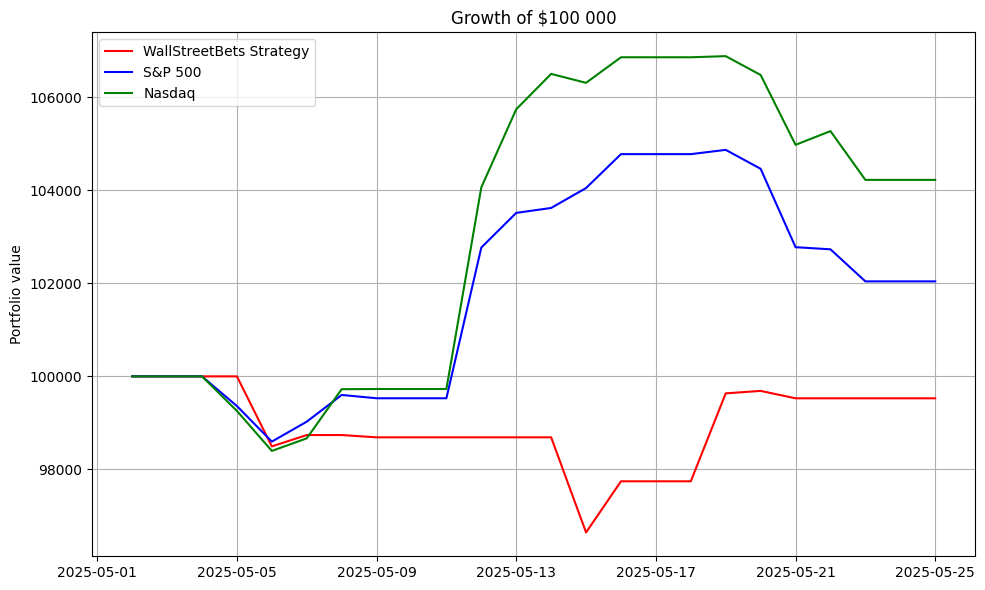

In [85]:
def cagr(curve):
    yrs = len(curve)/252
    return (curve.iloc[-1]/curve.iloc[0])**(1/yrs) - 1

def sharpe(r):
    return np.sqrt(252) * r.sub(RISK_FREE_RATE/252).mean() / r.std() if r.std()!=0 else np.nan

def max_dd(curve):
    return (curve/curve.cummax() - 1).min()

summary = pd.DataFrame({
    "Final $":   [strategy_eq.iloc[-1], *bench_eq.iloc[-1]],
    "CAGR %":    [cagr(strategy_eq), *[cagr(bench_eq[c]) for c in bench_eq]],
    "Sharpe":    [sharpe(strategy_ret), *[sharpe(bench_ret[c]) for c in bench_ret]],
    "Max DD %":  [max_dd(strategy_eq), *[max_dd(bench_eq[c]) for c in bench_eq]]
}, index=["Strategy", *bench_eq.columns]).round(3)

print(summary)

# Equity curves plot
plt.figure(figsize=(10,6))
strategy_eq.plot(label="WallStreetBets Strategy", color='red')
for col in bench_eq.columns:
    if col == "S&P 500":
        bench_eq[col].plot(label=col, color='blue')
    if col == "Nasdaq":
        bench_eq[col].plot(label=col, color='green')
plt.title("Growth of $100 000")
plt.ylabel("Portfolio value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

---

### 4. Visualization 